In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.set_printoptions(precision=3, suppress=True)

Before applying any machine learning algorithms, I wanted to see how each of the given predictors relate to each other.
To do it, I have found out pairplot() function from seaborn library which takes the name of columns (predictors) as
parameters and plots each one of them with another.

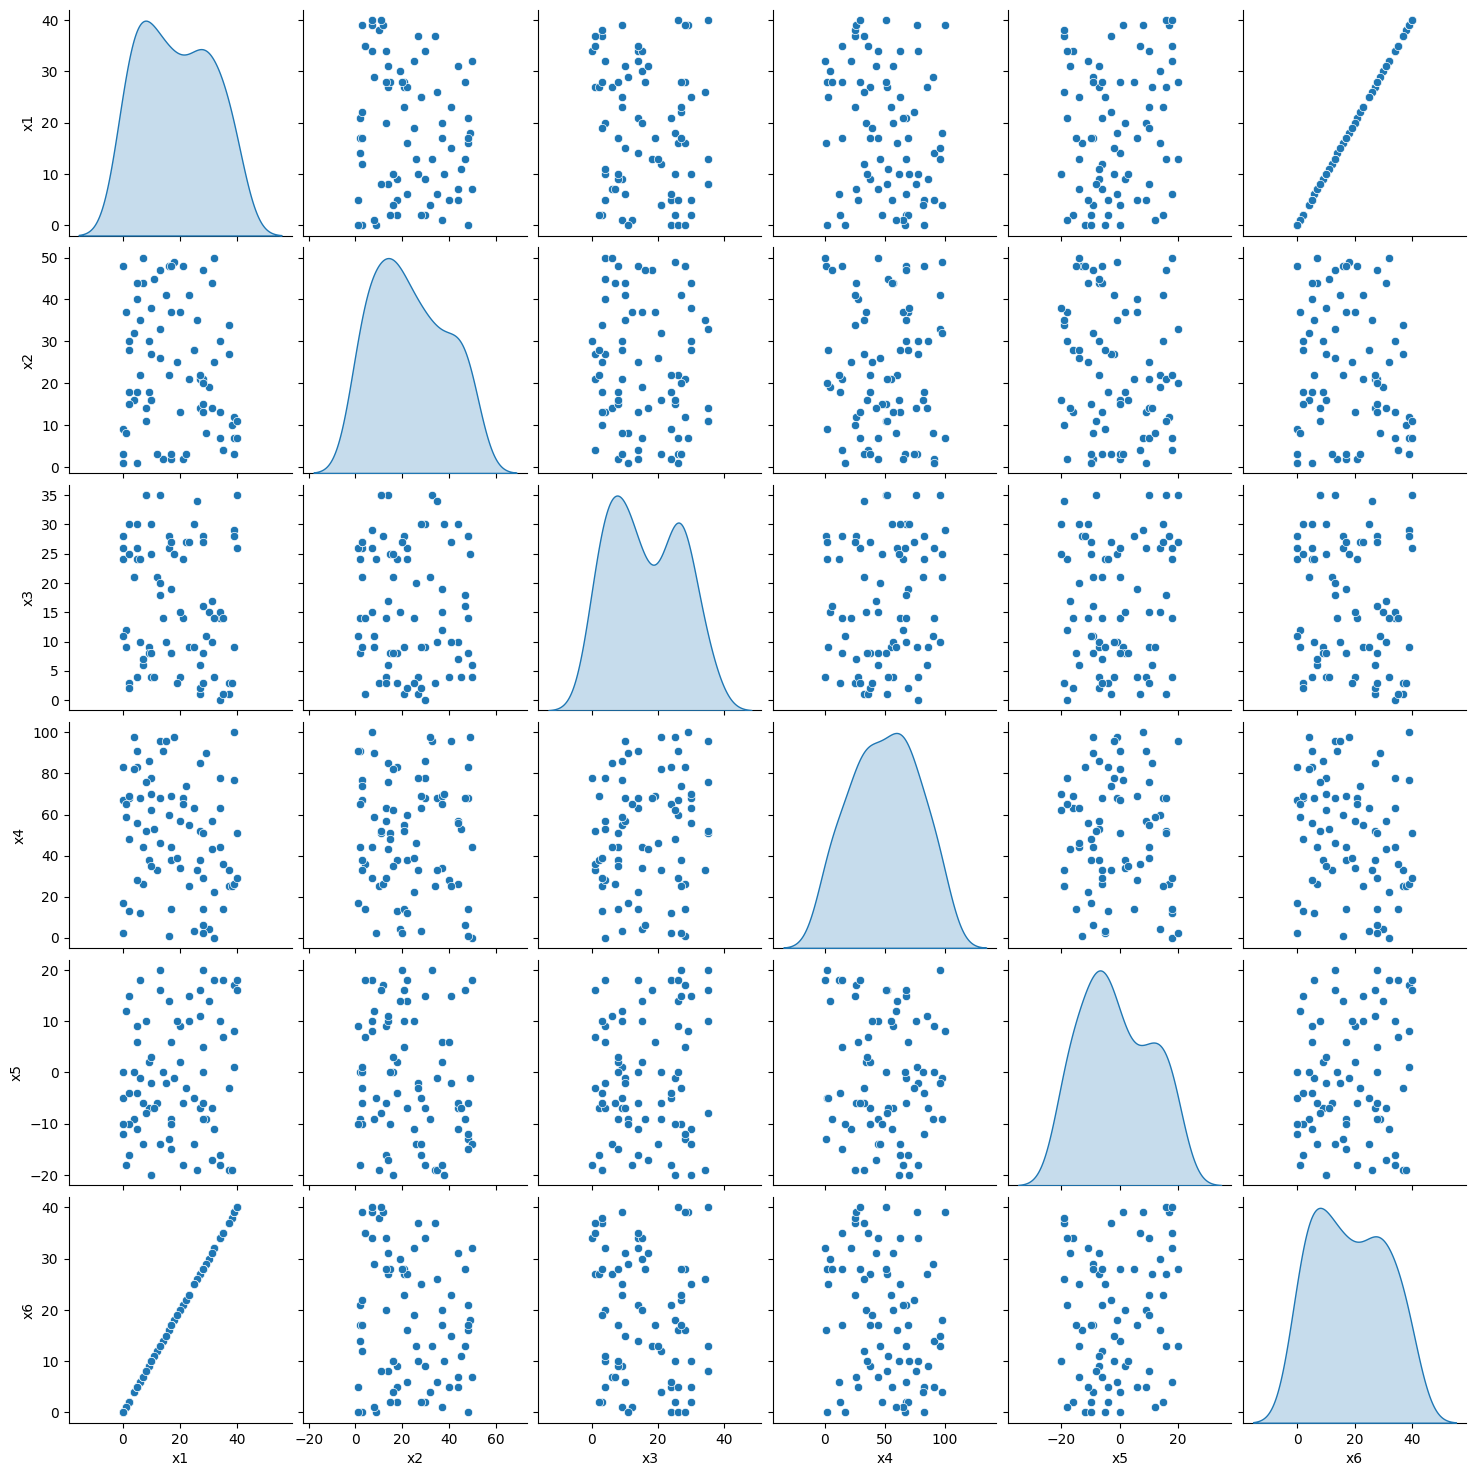

In [5]:
raw_dataset = pd.read_csv('dataset_v1.csv', sep=',', skipinitialspace=True)
dataset = raw_dataset.copy().dropna()

train_set = dataset.sample(frac=0.8, random_state=0)
test_set = dataset.drop(train_set.index)

sns.pairplot(train_set[['x1', 'x2', 'x3', 'x4', 'x5', 'x6']], diag_kind='kde')

From looking at the results, it is clear that x1 and x6 values are exactly the same. So, I have decided to drop x6
predictor since we do not need the same value twice.

Then, I wanted to see how each of those predictors relate to Y separately.

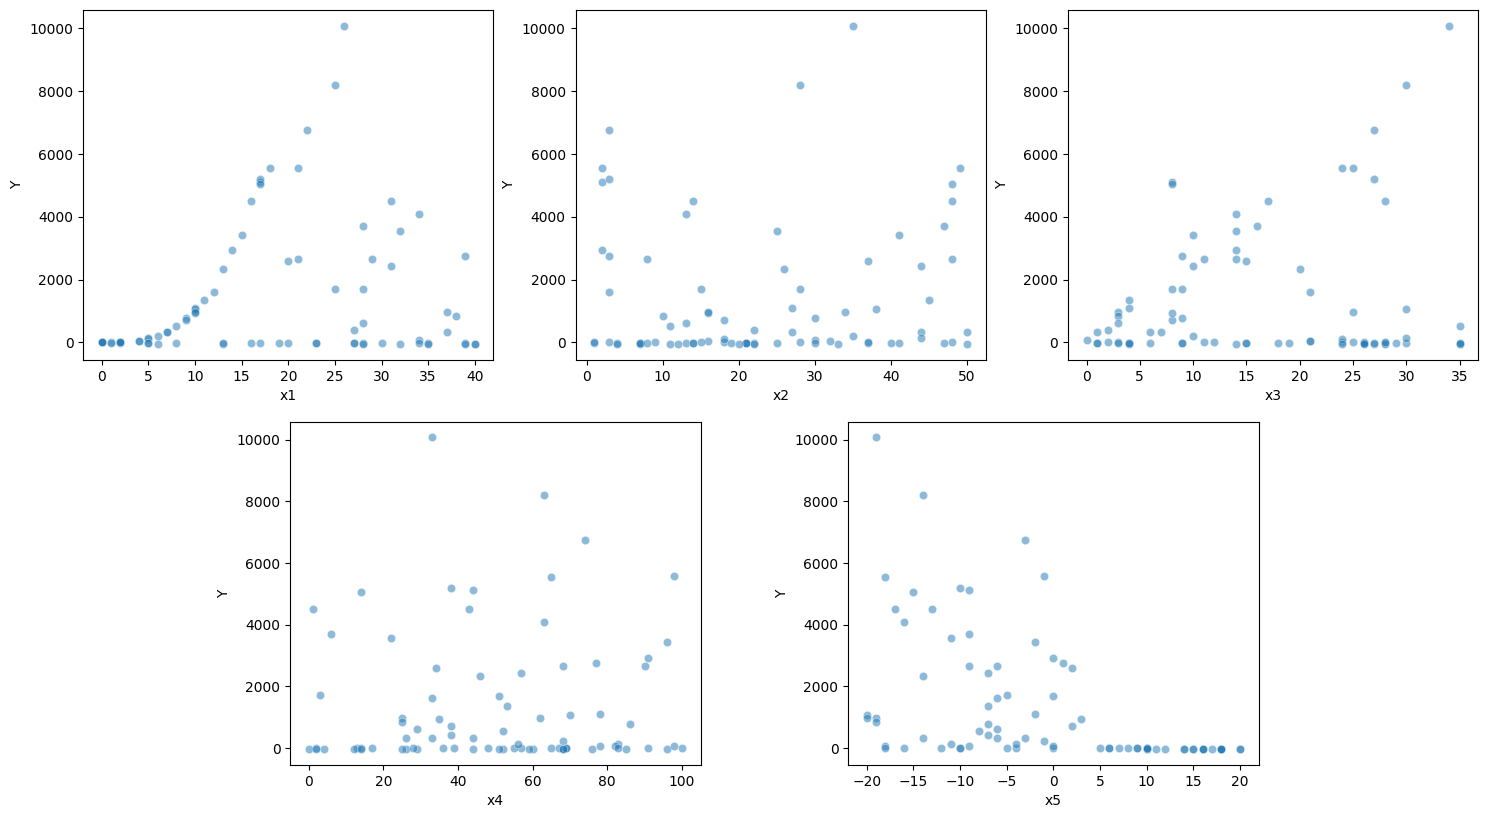

In [20]:
def scatter_plot_predictors(train_set_, y_, plot_func, predictors_):
    fig_, axes_ = plt.subplots(2, 3, figsize=(18, 10))
    axes_[1][2].set_visible(False)
    axes_[1][0].set_position([0.24,0.125,0.228,0.343])
    axes_[1][1].set_position([0.55,0.125,0.228,0.343])
    [plot_func(ax=axes_[i//3, i%3], x=train_set_[predictors_[i]], y=y_, alpha=0.5) for i in range(len(predictors_))]

predictors = ['x1', 'x2', 'x3', 'x4', 'x5']
scatter_plot_predictors(train_set, train_set['Y'], sns.scatterplot, predictors)

From here, I can see that when x1 has low values, their corresponding Y values are also tend to be low. Similarly,
when x5 has a value greater than 5, its corresponding Y value is very low.

The problem is, "very low" does not provide a clear metric, so I have decided to examine "low" and "high" Y values separately.

<AxesSubplot:xlabel='SampleNo', ylabel='Y'>

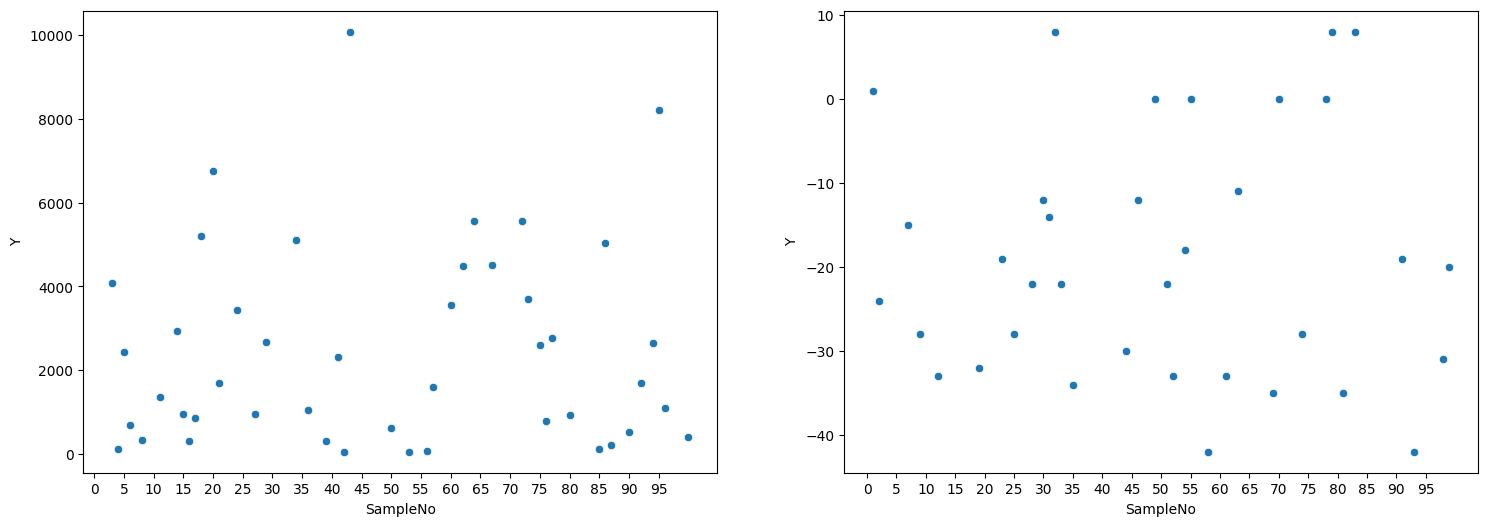

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
plt.setp(axes, xticks=np.arange(0, 100, 5))

limit = 50
lt_limit = train_set.copy()
lt_limit.drop(lt_limit[lt_limit['Y'] <= limit].index, inplace=True)
gt_limit = train_set.copy()
gt_limit.drop(gt_limit[gt_limit['Y'] > limit].index, inplace=True)

sns.scatterplot(ax=axes[0], x=lt_limit['SampleNo'], y=lt_limit['Y'])
sns.scatterplot(ax=axes[1], x=gt_limit['SampleNo'], y=gt_limit['Y'])

Separating points with Y values that are less than 50 from those are greater than 50 give those plots. It is not clear
that which model would fit those points the best, but it would be odd if it was that easy.